In [1]:
strategy_name ='状态转化'

In [2]:
import sys
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
sys.path.append(r"C:\Users\xudong\Documents\guanzhao\dataServer")
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import copy
from funcs import *
import pandas as pd
from operator import itemgetter
import TSLPy3 as tsl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib
import matplotlib.dates as mdates

np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang
dbt = client.tinySoftData

In [3]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1

In [4]:
def dtes2Label(dtes):
    return np.array([datetime.strptime(str(int(np.floor(d))), '%Y%m%d').date() for d in dtes])

In [153]:
startDate = 20170101
endDate = 20201026
ticker = 'IC1'
q = list(dbt.minuteBarContinuous.find({'derivedTicker':ticker, 'dateAsInt':{'$gte':startDate, '$lte':endDate}},{'dateTimeFloat':1, 'close':1, 'high':1, 'low':1}).sort('dateTimeFloat',1))
dtes = np.array([x['dateTimeFloat'] for x in q])
high_mtx = np.array([x['high'] for x in q])
low_mtx = np.array([x['low'] for x in q])
close_mtx = np.array([x['close'] for x in q])

dtesLabel = dtes2Label(dtes)

In [154]:
ret_mtx = np.zeros(close_mtx.shape)
ret_mtx[1:]=close_mtx[1:]/close_mtx[:-1]-1

In [155]:
# steps:
# 1. generate the channel at 3min, 15min, 120min
# 2. identify when it breaks 120min
# 3. 

In [166]:
def getDonchian(data, n=3, window=1):
    # n为抽样频率
    # window为回看几个bar
    dH = np.zeros(data.shape)
    dL = np.zeros(data.shape)
    for i in range(n*window, len(data)):
        dH[i] = np.max(data[i-n*window:i])
        dL[i] = np.min(data[i-n*window:i])
    return dH, dL
dH3min, dL3min = getDonchian(close_mtx, 3, 1)
dH15min, dL15min = getDonchian(close_mtx, 15, 1)
dH120min, dL120min = getDonchian(close_mtx, 120, 1)


In [167]:
def getStat(data, dH, dL):
    stat = np.zeros(close_mtx.shape)
    for i in range(2,len(stat)):
        if (data[i]>dH[i]):
            stat[i]=1
            continue
        if (data[i]<dL[i]):
            stat[i]=-1
            continue
        stat[i] = stat[i-1]
    return stat

In [168]:
stat3min = getStat(close_mtx, dH3min, dL3min)
stat15min = getStat(close_mtx, dH15min, dL15min)
stat120min = getStat(close_mtx, dH120min, dL120min)

In [169]:
t = stat3min+stat15min+stat120min

In [170]:
bt = np.zeros(close_mtx.shape)
bt[1:] = (t[:-1]!=3)&(t[1:]==3)
st = np.zeros(close_mtx.shape)
st[1:] = ((t[:-1]!=-3)&(t[1:]==-3))


In [171]:
countWindowBuy = 110 # 下单后统计窗口
countWindowSel = 110 # 下单后统计窗口
buyTrades = np.zeros((int(np.sum(bt)), countWindowBuy))
selTrades = np.zeros((int(np.sum(st)), countWindowSel))
idxB = np.nonzero(bt!=0)[0]
idxS = np.nonzero(st!=0)[0]
n = len(ret_mtx)
POSITION_buy = np.zeros(close_mtx.shape)
POSITION_sel = np.zeros(close_mtx.shape)
for (i,idx) in enumerate(idxB):
    if (idx+countWindowBuy<n):
        buyTrades[i] = np.cumsum(ret_mtx[idx+1:idx+countWindowBuy+1])
        POSITION_buy[idx+1:idx+countWindowBuy+1] = 1
for (i,idx) in enumerate(idxS):
    if (idx+countWindowSel<n):
        selTrades[i] = np.cumsum(-ret_mtx[idx+1:idx+countWindowSel+1])
        POSITION_sel[idx+1:idx+countWindowSel+1] = -1
        

In [176]:
isQuShi = 1

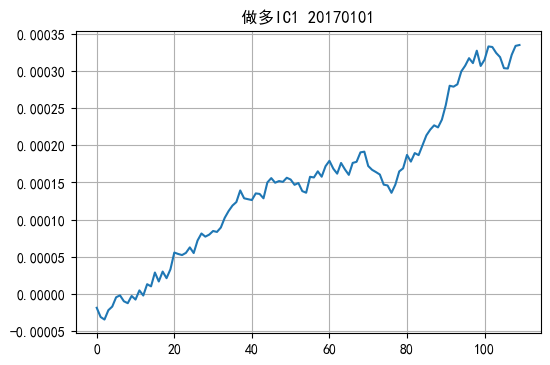

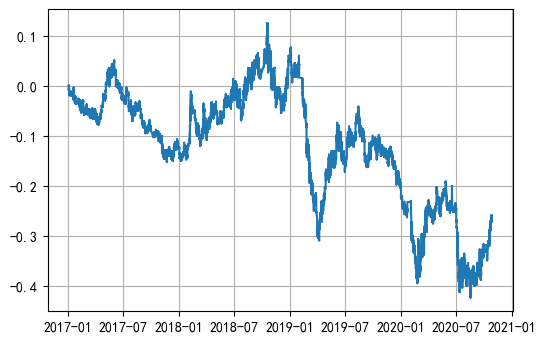

In [177]:
plt.title('做多'+ticker+' '+str(startDate))
plt.plot(np.mean(buyTrades, axis=0))
plt.grid()
plt.figure()
plt.plot(dtesLabel, np.cumsum(isQuShi * POSITION_buy * ret_mtx))
plt.grid()

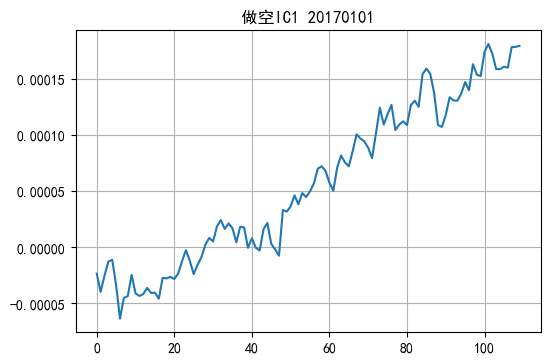

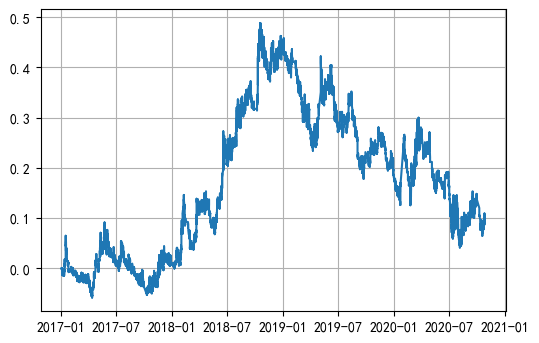

In [178]:
plt.title('做空'+ticker+' '+str(startDate))
plt.plot(np.mean(selTrades, axis=0))
plt.grid()
plt.figure()
plt.plot(dtesLabel, np.cumsum(isQuShi * -POSITION_sel * ret_mtx))
plt.grid()

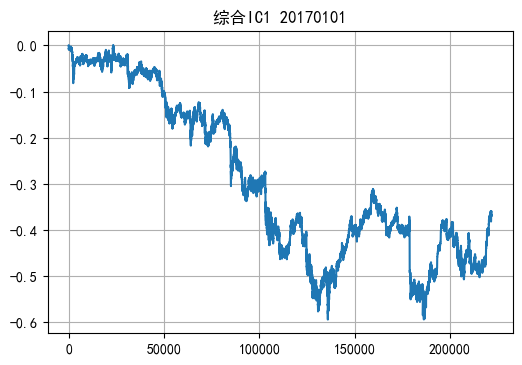

In [179]:
plt.title('综合'+ticker+' '+str(startDate))
plt.plot(np.cumsum(isQuShi * (POSITION_sel+POSITION_buy) * ret_mtx))
plt.grid()